EDA shows that some features present high colinearity. Highly colinear features can affect the stability of linear models.
We will use Lasso Regression because it automatically eleminates unecessary features and Random Forest because it is robust to features colinearity.

Another option we could explore to address features colinearity is:
- PCA
- Feature selection (eleminating features that don't improve evaluation scores)

We will use Root Mean Squarred Error  and R-squarred metric for model evaluation.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(8,5)})
from sklearn.model_selection import train_test_split
# for nice dark theme in Jupyter Notebooks
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.filterwarnings('once')

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error

from src.features.build_features import make_final_train_set
from src.models.algo_selection import get_df_errors

In [3]:
%load_ext autoreload
%autoreload 2

In [6]:
# Get the data
column_names, full_pipeline, df_train = make_final_train_set()
X_train = df_train.drop('mpg', axis=1)
y_train = df_train['mpg']

/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Corentin/anaconda3/envs/auto-mpg/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Algorithm selection 

### Lasso Regression 

In [7]:
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

alphas = [0.01 * i for i in range(1, 11)]
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42)

lasso_cv_results = cross_validate(lasso_cv, X_train, y_train, 
                                  cv=10,
                                  return_estimator=True, 
                                  return_train_score=True,
                                  scoring={'mse' : mse_scorer, 'r2' : r2_scorer},
                                  )
get_df_errors(lasso_cv_results)

,rmse,rmse_std,r2,r2_std
train,3.388,0.039,0.817,0.003
test,3.463,0.397,0.800,0.032


#####  Lasso params stabilty

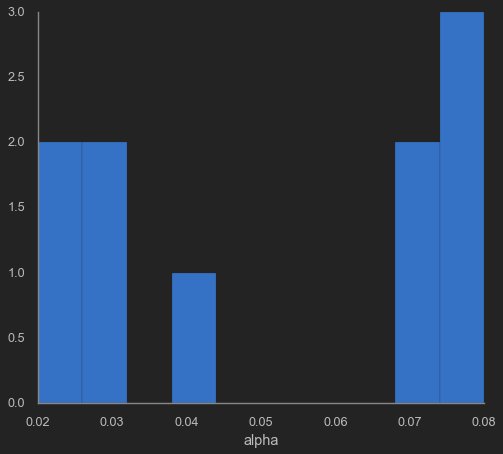

In [10]:
alphas = [model.alpha_ for model in lasso_cv_results['estimator']]
plt.hist(alphas)
sns.despine()
plt.xlabel('alpha')
plt.show()

In [11]:
print('alphas mean:', np.mean(alphas).round(3))
print('alphas std:', np.std(alphas).round(3))

alphas mean: 0.052
alphas std: 0.025


In [12]:
params = [model.coef_ for model in lasso_cv_results['estimator']]
df_lasso_cv_params = pd.DataFrame(np.stack(params), columns=X_train.columns)
df_lasso_cv_params

,displacement,horsepower,weight,acceleration,cylinders,year,x0_ASIA,x0_USA
0,0.000000,-0.227314,-4.824746,0.044674,0.000000,2.778478,0.00000,-2.173359
1,0.752941,-0.226636,-5.334845,0.152414,0.000000,2.898813,-0.00000,-2.249094
2,0.000000,-0.190502,-4.904144,0.000000,0.000000,2.773428,0.00000,-2.124895
3,0.945262,-0.345464,-5.525247,0.065025,-0.000000,2.903835,0.00000,-2.130423
4,1.637823,-0.658986,-5.559828,0.182798,-0.282363,2.876234,-0.05707,-2.486381
5,0.000000,-0.123614,-5.070797,0.000000,0.000000,2.849451,-0.00000,-1.416299
6,0.000000,-0.137964,-4.955586,0.000000,0.000000,2.790494,0.00000,-1.702885
7,0.000000,-0.320430,-4.851979,0.000000,0.000000,2.831258,0.00000,-1.774325
8,1.605187,-0.000000,-6.204168,0.237987,0.000000,3.038612,0.00000,-2.481290
9,1.044197,-0.475809,-5.323890,0.083855,-0.000000,2.824131,0.00000,-2.683538


In [13]:
df_lasso_cv_params.describe().loc[['mean', 'std'], :]

,displacement,horsepower,weight,acceleration,cylinders,year,x0_ASIA,x0_USA
mean,0.598541,-0.270672,-5.255523,0.076675,-0.028236,2.856473,-0.005707,-2.122249
std,0.685352,0.189645,0.431047,0.086761,0.089291,0.079348,0.018047,0.393080


Lasso coefficients varies with the training example. The Lasso model seems instable accross teh different training samples.
Tibshirani identified the conditions for Lasso "uniqueness" in this 2013 paper [[1]](https://projecteuclid.org/download/pdfview_1/euclid.ejs/1369148600).
One of these conditions is continuous features. Cylinders, Year and Region are categorical.
Usefull papers to read about Lasso model unstability:
- [Sparse Algorithms are not Stable](http://users.ece.utexas.edu/~cmcaram/pubs/XuCaramanisMannor.NFL.pdf)
- [The lasso problem and uniqueness](https://projecteuclid.org/download/pdfview_1/euclid.ejs/1369148600)
- [Stack overflow question and answers](https://stats.stackexchange.com/questions/365938/what-causes-lasso-to-be-unstable-for-feature-selection)


### Random Forest 

In [20]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
             ]
rf = RandomForestRegressor(random_state=42)

rfcv = GridSearchCV(rf,
                    param_grid,
                    cv=10,
                    return_train_score=True,
                    n_jobs=-1)

rfcv_results = cross_validate(rfcv, X_train, y_train, 
                              cv=10,
                              return_estimator=True, 
                              return_train_score=True,
                              n_jobs=-1,
                              scoring={'mse': mse_scorer, 'r2': r2_scorer},
                           )
get_df_errors(rfcv_results)

,rmse,rmse_std,r2,r2_std
train,1.128,0.035,0.980,0.001
test,2.846,0.504,0.863,0.042


In [15]:
# Let's compare it with results from Lasso cv
get_df_errors(lasso_cv_results)

,rmse,rmse_std,r2,r2_std
train,3.388,0.039,0.817,0.003
test,3.463,0.397,0.800,0.032


#####  RF params statbilty

In [22]:
[model.best_params_ for model in rfcv_results['estimator']]

[{'max_features': 2, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 4, 'n_estimators': 30}]

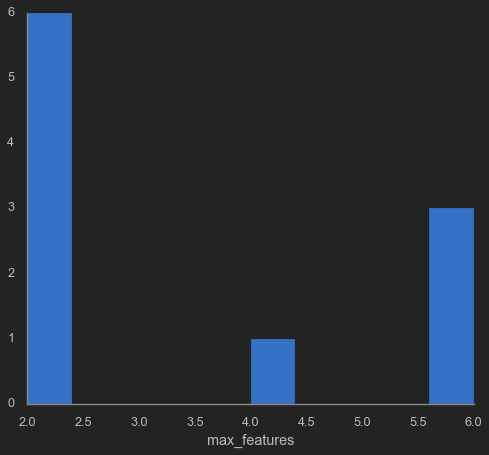

In [23]:
max_features = [model.best_params_['max_features'] for model in rfcv_results['estimator']]
plt.hist(max_features)
sns.despine()
plt.xlabel('max_features')
plt.show()

#### Conclusion
Random Forest cross-validated yields to better rmse and r2 scores on the test set compared to Lasso cross-validated.

Random Forest is probably overfit the training set. Regularization might help with overfitting.

There is a variablity in `max_features` parameter. The relatively small size of the training set might cause this instablity.

Given these results, we will pick Random Forest algorithm. We won't use nested cross-validation but simple cross-validation to finetuning.  The model will access more instances to train on.
